In [1]:
import torch
import os
import skimage
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from training.wandblogger import WandBLogger2D
from training.trainer import MRTrainer
from datasets.imagesignal import ImageSignal
from networks.mrnet import MRFactory
from networks.siren import Siren
from datasets.pyramids import create_MR_structure
import yaml
from yaml.loader import SafeLoader
from training.loss import gradient
from datasets.sampling import make2Dcoords
import matplotlib.pyplot as plt


#### MR-Net Config & Data Source

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "s-net.ipynb"
BASE_DIR = Path('.').absolute().parents[0]
IMAGE_PATH = BASE_DIR.joinpath('img')

In [3]:
project_name = "test_sgrad"

# hyperparameters
with open('../configs/config_base_l_net.yml') as f:
    hyper = yaml.load(f, Loader=SafeLoader)
    print(hyper)


{'omega_0': 32, 'in_features': 2, 'hidden_features': 256, 'hidden_layers': 3, 'superposition_w0': True, 'hidden_omega_0': 30, 'sampling_scheme': 'uniform', 'multiresolution': 'capacity', 'max_epochs_per_stage': 200, 'opt_method': 'Adam', 'loss_function': ['d0'], 'lr': 0.0001, 'loss_tol': 1e-14, 'diff_tol': 1e-11, 'batch_pixels_perc': 0.5, 'batch_size': 1, 'image_name': 'camera.png', 'width': 512, 'height': 512, 'channels': 1, 'max_stages': 1, 'model': 'L', 'useattributes': True, 'device': 'cuda', 'eval_device': 'cuda', 'bias': False}


In [4]:
base_signal = ImageSignal.init_fromfile(
                    os.path.join(IMAGE_PATH, hyper['image_name']),
                    useattributes=hyper.get('useattributes', False),
                    batch_pixels_perc=1,
                    width=hyper['width'],height= hyper['height'])
hyper['width'], hyper['height'] = base_signal.dimensions()


#### SIREN Data Source

In [5]:
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [6]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor()
    ])
    img = transform(img)
    return img

In [7]:
import scipy.ndimage
    
class PoissonEqn(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_cameraman_tensor(sidelength)
        
        # Compute gradient and laplacian       
        grads_x = scipy.ndimage.sobel(img.numpy(), axis=1).squeeze(0)[..., None]
        grads_y = scipy.ndimage.sobel(img.numpy(), axis=2).squeeze(0)[..., None]
        grads_x, grads_y = torch.from_numpy(grads_x), torch.from_numpy(grads_y)
                
        self.grads = torch.stack((grads_x, grads_y), dim=-1).view(-1, 2)
        
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return {'coords': self.coords}, {'d0':self.pixels, 'd1':self.grads}

In [8]:
cameraman = PoissonEqn(128)

### Select Data Source

In [9]:
# base_signal or cameraman
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

### SIREN Net & Training

In [10]:

poisson_siren = Siren(in_features=2, out_features=1, first_omega_0=30, hidden_omega_0= 30, hidden_features=256, hidden_layers=3, outermost_linear=True)
poisson_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [11]:
def gradients_mse(model_output, coords, gt_gradients):
    # compute gradients on the model
    gradients = gradient(model_output, coords)
    gt_grads = gt_gradients.view(1,-1,2)
    # compare them with the ground-truth
    gradients_loss = torch.mean((gradients - gt_grads).pow(2).sum(-1))
    return gradients_loss

Step 0, Total loss 4.521358


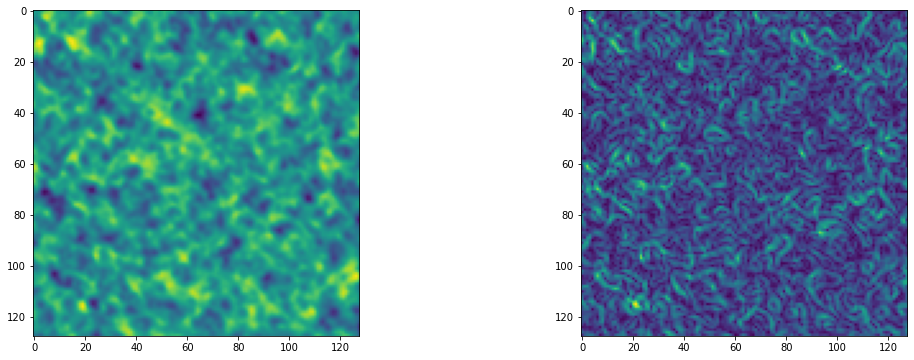

Step 10, Total loss 0.550139


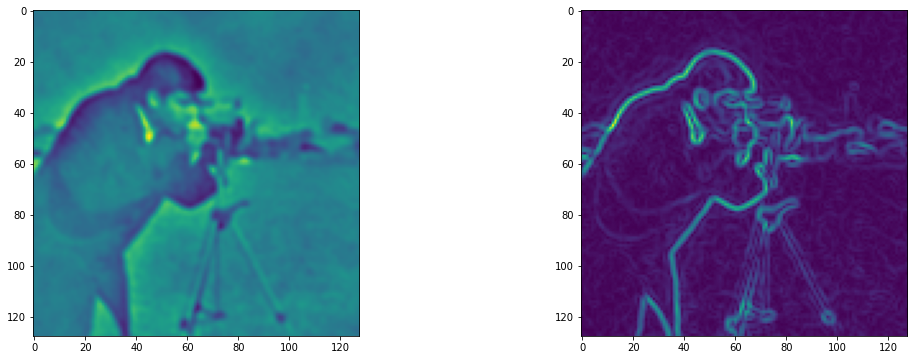

Step 20, Total loss 0.200679


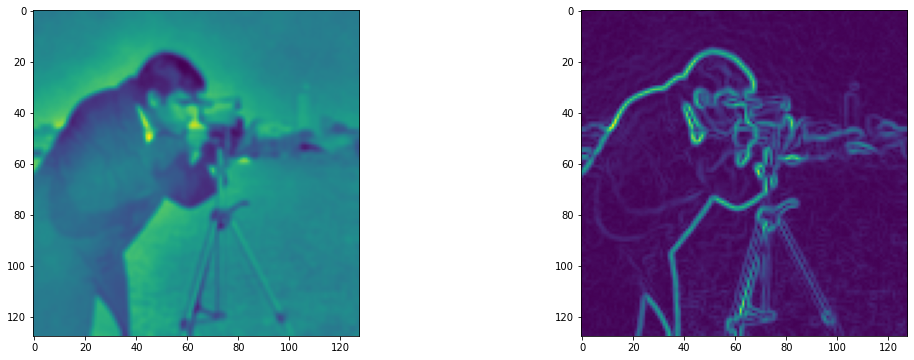

Step 30, Total loss 0.098997


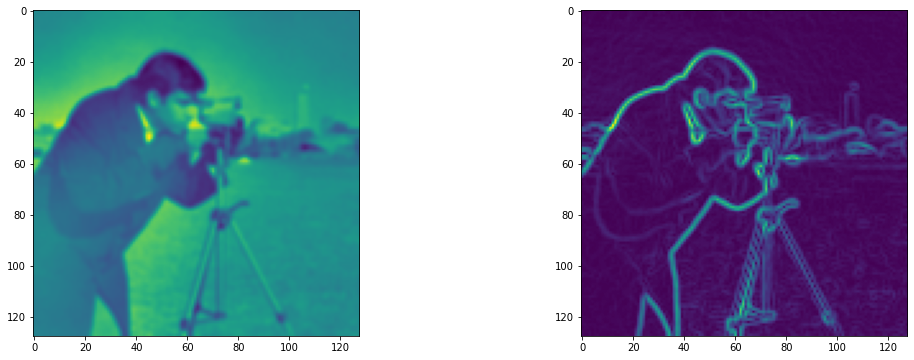

Step 40, Total loss 0.056115


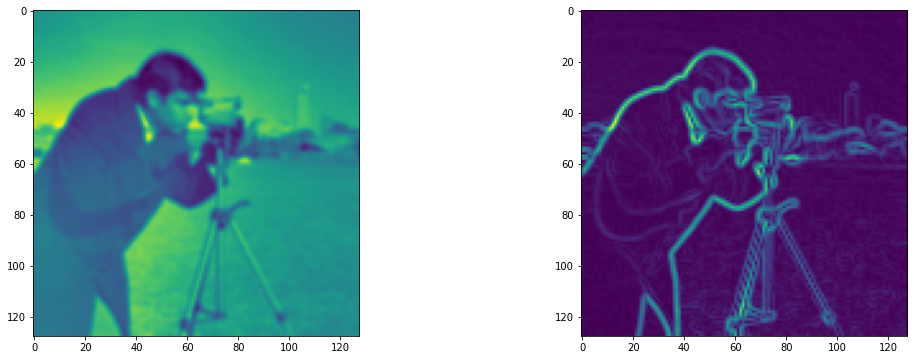

Step 50, Total loss 0.034626


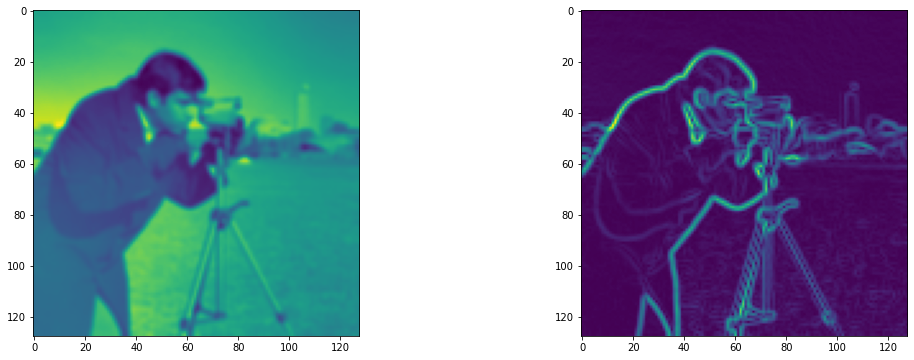

Step 60, Total loss 0.023437


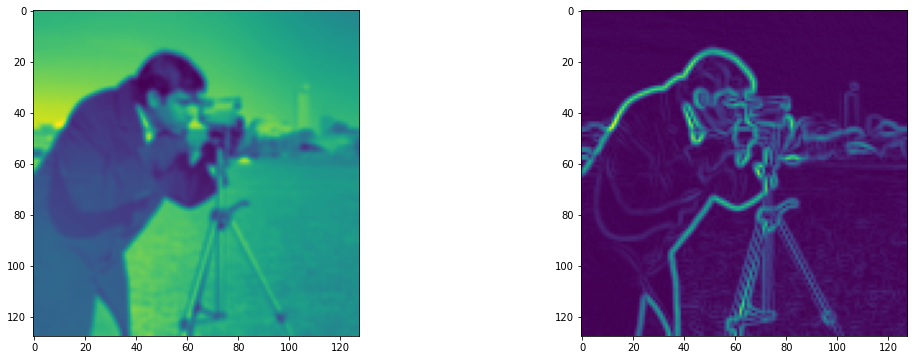

Step 70, Total loss 0.017062


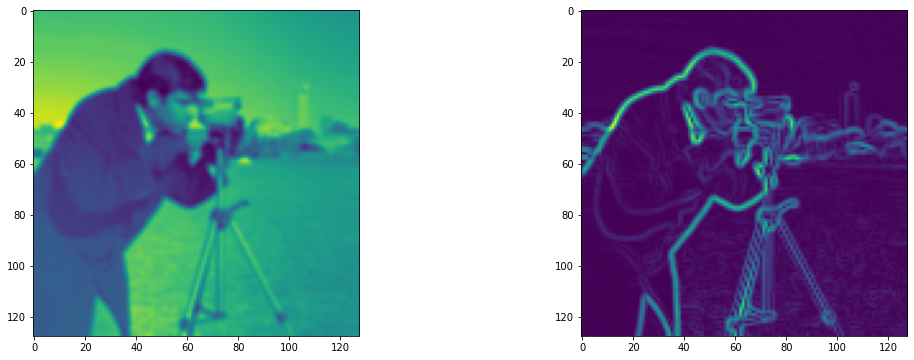

Step 80, Total loss 0.013114


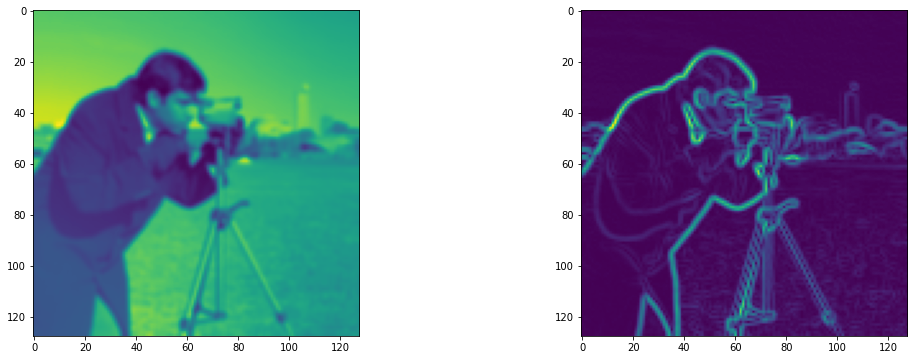

Step 90, Total loss 0.010537


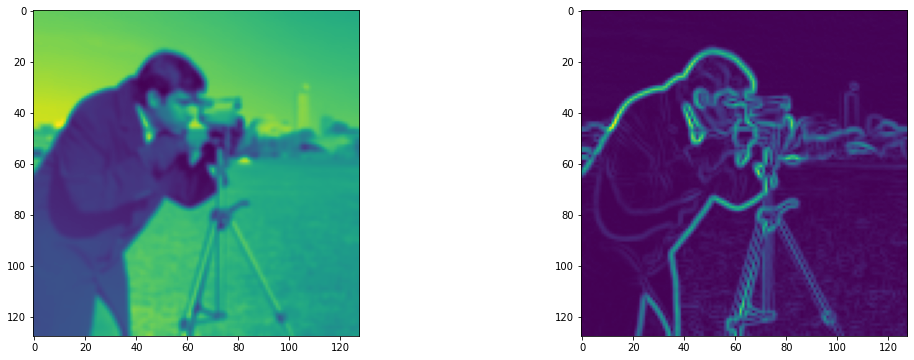

In [12]:
total_steps = 100
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=poisson_siren.parameters())

model_input, gt = next(iter(dataloader))
gt = {key: value.cuda() for key, value in gt.items()}
model_input = model_input['coords'].cuda()

for step in range(total_steps):

    model_output, coords = poisson_siren(model_input)
    train_loss = gradients_mse(model_output, coords, gt['d1'])

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, train_loss))

        img_grad = gradient(model_output, coords)

        fig, axes = plt.subplots(1, 2, figsize=(18, 6))

        axes[0].imshow(model_output.cpu().view(128,128).detach().numpy())
        axes[1].imshow(img_grad.cpu().norm(dim=-1).view(128,128).detach().numpy())
        plt.show()
        
    optim.zero_grad()
    train_loss.backward()
    optim.step()